In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [1]:
from helpers import load_data

# load dataset
x, y = load_data()

In [2]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [52]:
a = build_k_indices(y, 3, 1)
print(a)
print(a[[0,2],:])
np.arange(3)
x[a[2,:]]

[[27 35 40 38  2  3 48 29 46 31 32 39 21 36 19 42]
 [49 26 22 13 41 17 45 24 23  4 33 14 30 10 28 44]
 [34 18 20 25  6  7 47  1 16  0 15  5 11  9  8 12]]
[[27 35 40 38  2  3 48 29 46 31 32 39 21 36 19 42]
 [34 18 20 25  6  7 47  1 16  0 15  5 11  9  8 12]]


array([4.39037348, 0.47856237, 4.51656093, 1.36187455, 3.88562366,
       5.65224803, 4.13799857, 4.8951233 , 6.15699785, 0.35237491,
       5.39987312, 0.73093728, 3.63324875, 2.37137419, 6.28318531,
       0.85712473])

In [50]:
print(a)
np.delete(a,1,0)
x[np.delete(a,1,0)].ravel()

[[27 35 40 38  2  3 48 29 46 31 32 39 21 36 19 42]
 [49 26 22 13 41 17 45 24 23  4 33 14 30 10 28 44]
 [34 18 20 25  6  7 47  1 16  0 15  5 11  9  8 12]]


array([5.77843549, 3.00231147, 2.6237491 , 5.02131076, 1.86662437,
       3.50706129, 2.74993656, 1.2356871 , 5.90462294, 1.99281183,
       1.48806201, 5.52606058, 0.98331219, 0.22618746, 2.87612401,
       3.12849893, 4.39037348, 0.47856237, 4.51656093, 1.36187455,
       3.88562366, 5.65224803, 4.13799857, 4.8951233 , 6.15699785,
       0.35237491, 5.39987312, 0.73093728, 3.63324875, 2.37137419,
       6.28318531, 0.85712473])

In [70]:
from costs import compute_loss_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly
import numpy as np

def cross_validation(y, x, k_indices, k, lambda_, degree):    
    """ CROSS_VALIDATION Finds loss of k-fold ridge regresion
        Calculates the RMSE loss of using a k-fold technique
        Using the the k'th fold as a testing set and the other folds
        as a training set.
        
        INPUTS
        y (N x 1): array of the output data with N datapoints
        x (N x 1): array of the input data with N datapoints and D characteristics
        k_indices (K x (N/K)): an array of the fold indices. K being number of folds
        lambda_: tradeoff parameter for ridge regression
        
        OUTPUTS
        loss_tr: RMSE loss of the model on the training data
        loss_te: RMSE loss of the model on the test data
    """
    # get k'th subgroup in test, others in train: TODO
    train_x = x[np.delete(k_indices,k,0)].ravel()
    test_x = x[k_indices[k,:]]
    train_y = y[np.delete(k_indices,k,0)].ravel()
    test_y = y[k_indices[k,:]]
    
    # form data with polynomial degree
    train_poly = build_poly(train_x, degree)
    test_poly = build_poly(test_x, degree)
    
    # ridge regression
    loss_tr, weights = ridge_regression(train_y, train_poly, lambda_)
    
    # calculate loss for test data
    loss_te = compute_loss_mse(test_y, test_poly, weights)
    
    return loss_tr, np.sqrt(loss_te)

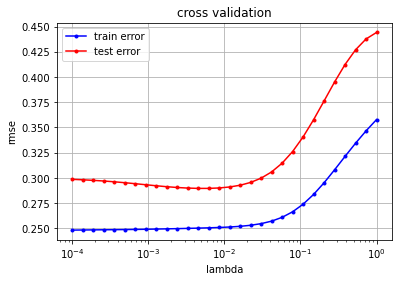

In [74]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = np.zeros(len(lambdas))
    rmse_te = np.zeros(len(lambdas))
    for ind, lambda_ in enumerate(lambdas):
        for k in range(k_fold):
            # ridge regression with a given lambda and fold
            temp_rmse_tr, temp_rmse_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr[ind] = rmse_tr[ind] + temp_rmse_tr
            rmse_te[ind] = rmse_te[ind] + temp_rmse_te
        # average the losses over number of folds
        rmse_tr[ind] = rmse_tr[ind] / k_fold
        rmse_te[ind] = rmse_te[ind] / k_fold

    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

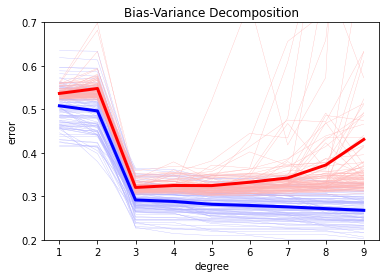

In [89]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    mse_tr = np.empty((len(seeds), len(degrees)))
    mse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # split data with a specific seed
        train_x, train_y, test_x, test_y = split_data(x, y, ratio_train, seed)
                
        for index_degree, degree in enumerate(degrees):
            # form train and test data with polynomial basis function
            train_poly = build_poly(train_x, degree)
            test_poly = build_poly(test_x, degree)
            
            mse_tr[index_seed, index_degree], w = least_squares(train_y, train_poly)
            mse_te[index_seed, index_degree] = compute_loss_mse(test_y, test_poly, w)

    bias_variance_decomposition_visualization(degrees, np.sqrt(mse_tr), np.sqrt(mse_te))

bias_variance_demo()